This script is specifically to create a heatmap of the 3496 data at an appropriate size for the MS&T poster.

# Imports

In [1]:
#science imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy import stats

#standard library imports
import copy
import glob
import os
import os.path as path
import time

#PyMca imports
from PyMca5.PyMca import McaAdvancedFitBatch as batch
from PyMca5.PyMcaPhysics.xrf.XRFBatchFitOutput import OutputBuffer

# Set path label for file reading
This is the YYYYMMDD_CVD_XXXX label at the beginning of the XRF map folder.

In [2]:
path_label = "20230613_CVD_3496"

sample_name = "CVD" + path_label[-4:]

# File reading

## Prepare data arrays
Determine grid resolution and create empty data arrays in preparation for reading

In [3]:
#set number of points and dimensions of scan
#grid_size is number of steps in the grid x and y axes
#grid_dim is the actual length of the sides of the square scanned by the grid, in mm

if len(glob.glob("./"+path_label+"_map/*.spx")) == 200:
    grid_size = 10
    grid_dim = 15
elif len(glob.glob("./"+path_label+"_map/*.spx")) == 800:
    grid_size = 20
    grid_dim = 0.5
else:
    raise FileNotFoundError("Folder contains neither 200 nor 800 .spx files.")

print("{0}x{0} grid".format(grid_size))

#dat["Xx_Yy_dZ"] contains data from element Xx, characteristic line Yy, detector Z
dat = {
    "Si_ka_d1": np.zeros((grid_size, grid_size)),
    "Si_ka_d2": np.zeros((grid_size, grid_size)),
    "Ga_ka_d1": np.zeros((grid_size, grid_size)),
    "Ga_ka_d2": np.zeros((grid_size, grid_size)),
    "Ga_kb_d1": np.zeros((grid_size, grid_size)),
    "Ga_kb_d2": np.zeros((grid_size, grid_size)),
    "Ga_l_d1":  np.zeros((grid_size, grid_size)),
    "Ga_l_d2":  np.zeros((grid_size, grid_size)),
    "P_ka_d1":  np.zeros((grid_size, grid_size)),
    "P_ka_d2":  np.zeros((grid_size, grid_size))
}

10x10 grid


## PyMca
Format is ;-separated csv file. First row is headers. The first two columns are a row and column entry. PyMca assumes that your data are in a grid but it doesn't know how our data are arranged, so it just dumps them all into a list of rows. Thankfully, the list has all our data ordered 0_0, 0_1, 0_2, etc. This means the row number can be used to determine the x and y coordinates of the spectrum with a bit of math. The y coordinate is row # mod 10, and the x coordinate is (row number / 10) mod 10. For grids with a different size (e.g. 20x20) the 10 is replaced with the size of the grid.

In [4]:
source = "PyMca"

#glob can be used here because there is only one csv file, and it is useful in case the file name format changes
input_file = open(glob.glob("./" + path_label + "_map/fits_out/IMAGES/*.csv")[0], "r")

s = input_file.readline().split(";")

while s != [""]:
    
    #only read lines that start with a number
    #also, only read lines in column zero. When PyMca does batch fits on .spx
    #files, it will interpret the SNIP background from the bruker software as
    #its own spectrum, and fit both the actual spectrum and the background as
    #though they were both spectra. When it does this, the csv file contains
    #peak areas from the actual spectrum in column 0, and peak areas from the
    #background in column 1.
    if s[0][0].isnumeric() and s[1] == "0": 
        
        index = int(s[0]) #file index is first in the line
        x = int(((index)/grid_size) % grid_size)
        y = int((index) % grid_size)
        
        si_counts = float(s[2])
        ga_ka_counts = float(s[8])
        ga_kb_counts = float(s[9])
        #combine data from La1, La2, La3 since they are indistuinguishable with Si(Li) detector
        ga_l_counts = float(s[10]) + float(s[11]) + float(s[12])
        p_counts = float(s[4])
        
        if int(s[0]) < grid_size**2 : #separate into detector 1 and detector 2
            dat["Si_ka_d1"][y][x] = si_counts
            dat["Ga_ka_d1"][y][x] = ga_ka_counts
            dat["Ga_kb_d1"][y][x] = ga_kb_counts
            dat["Ga_l_d1"][y][x] = ga_l_counts
            dat["P_ka_d1"][y][x] = p_counts
            
        elif int(s[0]) >= grid_size**2:
            dat["Si_ka_d2"][y][x] = si_counts
            dat["Ga_ka_d2"][y][x] = ga_ka_counts
            dat["Ga_kb_d2"][y][x] = ga_kb_counts
            dat["Ga_l_d2"][y][x] = ga_l_counts
            dat["P_ka_d2"][y][x] = p_counts

    s = input_file.readline().split(";")
        
input_file.close()

# Heatmap
These cells plot heatmaps of the data.

## Contour map
This cell plots the data with `contourf()`, resulting in a smoothed plot with discrete levels.

In [5]:
ms = 20 #marker size
title_font = {"fontsize": 36}
legend_font_size = 20
axes_font = {"fontsize": 30}
tick_label_size = 20
fit_line_size = 3
grid_width = 0.4

figure_size = (8, 7)

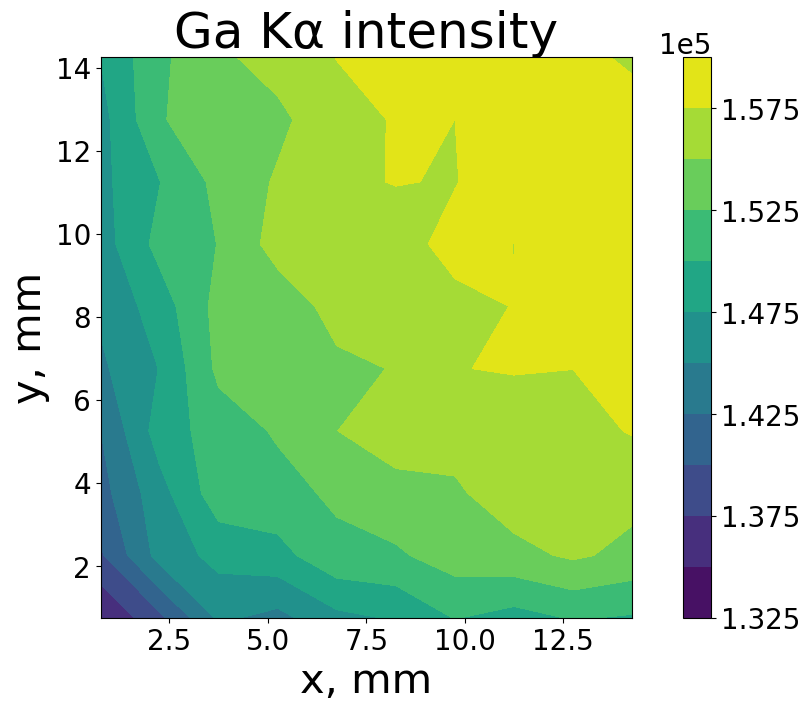

In [6]:
c="viridis" #colormap to use
l = 10 #how many levels in the contour map

fg, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size, layout="constrained")

im_pointer = ax.contourf(dat["Ga_ka_d1"], levels = l, extent = [0, grid_dim, 0, grid_dim], cmap=c, origin = "lower")

cb = plt.colorbar(im_pointer, ax=ax)
cb.formatter.set_powerlimits((-5,5))
cb.ax.tick_params(axis="both", which="major", labelsize=tick_label_size) #color bar label size
cb.ax.yaxis.get_offset_text().set_fontsize(tick_label_size) #color bar scientific notation size

ax.tick_params(axis="both", which="major", labelsize=tick_label_size)
ax.set_title("Ga K\u03b1 intensity", fontdict=title_font)
ax.set_xlabel("x, mm", fontdict=axes_font)
ax.set_ylabel("y, mm", fontdict=axes_font)

#fg.suptitle(sample_name + " maps from " + source)

plt.show()
#plt.savefig()

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right

## Contour map with thickness instead of intensity

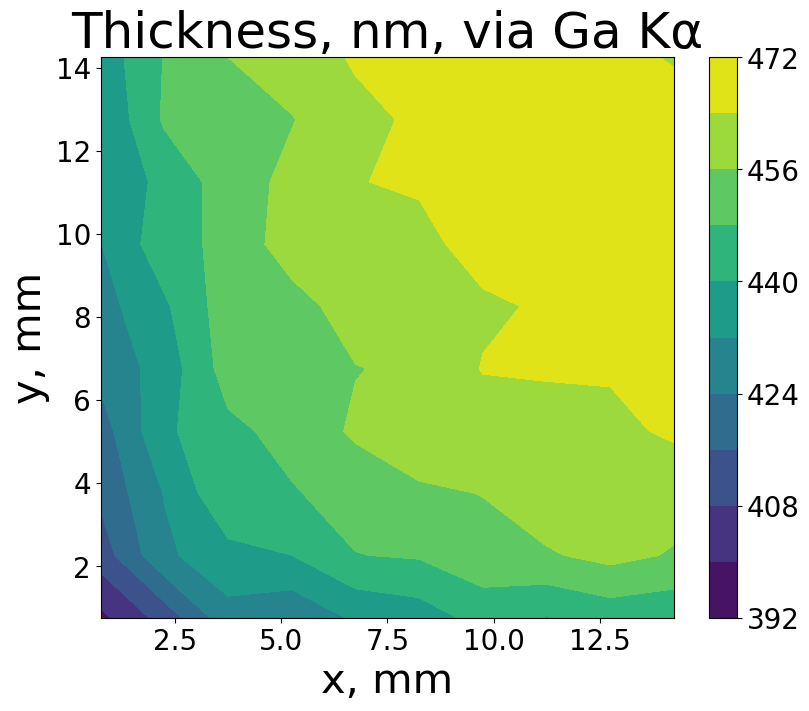

In [10]:
c="viridis" #colormap to use
l = 10 #how many levels in the contour map

fg, ax = plt.subplots(nrows=1, ncols=1, figsize=figure_size, layout="constrained")

dat_thickness = (dat["Ga_ka_d1"]-256.75)/338.41

im_pointer = ax.contourf(dat_thickness, levels = l, extent = [0, grid_dim, 0, grid_dim], cmap=c, origin = "lower")

cb = plt.colorbar(im_pointer, ax=ax)
cb.formatter.set_powerlimits((-5,5))
cb.ax.tick_params(axis="both", which="major", labelsize=tick_label_size) #color bar label size
cb.ax.yaxis.get_offset_text().set_fontsize(tick_label_size) #color bar scientific notation size

ax.tick_params(axis="both", which="major", labelsize=tick_label_size)
ax.set_title("Thickness, nm, via Ga K\u03b1", fontdict=title_font)
ax.set_xlabel("x, mm", fontdict=axes_font)
ax.set_ylabel("y, mm", fontdict=axes_font)

#fg.suptitle(sample_name + " maps from " + source)

plt.show()
#plt.savefig()

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right